In [ ]:
!pip install openml

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

RANDOM_SEED = 0xdeadbeef

# Task 1: Warmup - Breast Cancer Classification (3 Points)

In this warm-up task, we you will apply what you have learned so far about classification to a dataset of Breast Cancer samples. The dataset has 30 features and the goal is to predict whether a particular example is malignant or benign. In further tasks, we will apply dimensionality reduction techniques to this dataset. The goal of this first task is to establish a baseline that we can compare against.

In the next cell, we load the data and print out the description of the dataset. You do not have to read it in detail but we suggest you have a quick look at what kind of measurements were taken.

In [ ]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True)
X_raw = data.data
y = data.target
y.replace(0, 'Malignant', inplace=True)
y.replace(1, 'Benign', inplace=True)

print(data.DESCR)

In the next cell, we split the data in a train and test set. We select $80\%$ of the data for training and the remaining to test. We also use stratification to make sure that the proportion of malignant and benign samples is the same in both the train and test set.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
  X_raw, y,
  train_size=.8,  # use 80% for training
  shuffle=True,   # randomize the split
  random_state=RANDOM_SEED,  # set the random seed, so we always  get the same split 
  stratify=y,  # stratify, to make sure class proportions are preserved
)

# Normalizing the data

###  Task 1a. Apply standard (mean, standard deviation) normalization to both the training and the test data. 

**Remember:** we only compute the the mean and standard deviation on the training set!

In [ ]:
mean = x_train.mean()
std = x_train.std()

x_train_norm = (x_train - mean)/std
x_test_norm = (x_test - x_test.mean())/x_test.std()

# What is the performance of a Linear SVM classifier on this data?

We are now ready to train our baseline classifier on this data. Since we will compare different classifiers to each other, it is useful to have a single score that we can compare.

In the next cell, we provide a helper function to compute the F1 score for 'Malignant' predictions. We will use this function to compare classifiers.

In [ ]:
from sklearn.metrics import f1_score

def f1_malignant(y_true: pd.Series, y_pred: pd.Series) -> float:
  """
  Helper function to compute the F1 score for the 'Malignant' class

  y_true: a pd.Series object containing the ground truth labes 
          ('Benign' or 'Malignant'), you will mainly pass 'y_test' here
  y_pred: a pd.Series object containing predicted labels, for example the 
          output of the '.predict' method of a classifier
  """
  return f1_score(
      y_true=y_true,
      y_pred=y_pred,
      pos_label="Malignant",
      average="binary",
  )

### TASK1b. In the next cell, your task is to train linear SVM classifiers. We set up the loops to search for good values of the hyperparameters `C` and `class_weight` for you.

Find the combination that gives the best (i.e. highest) value for `f1_malignant`.

In [ ]:
from sklearn.svm import LinearSVC

for c in [.1, 1., 10.]:
  for class_weight in [None, "balanced"]:
    svm = LinearSVC(C=c, class_weight=class_weight)
    # fit svm
    svm.fit(x_train, y_train)
    # compute f1_malignant
    y_pred = svm.predict(x_test)
    f1score = f1_malignant(y_test, y_pred)
    # find the best combination of C and class_weight
    print(f"c:{c} class_weight:{class_weight} f1_score:{f1score}")

Best score: c:1.0 class_weight:None f1_score:0.925

## 📢 **HAND-IN** 📢: Enter in **Moodle** whether you solved this task.

# Task 2: PCA (5 Points)

We will now apply Principal Component Analysis (PCA) to our data. At its core, PCA will just map our data into a new coordinate systems in such a way that the variation in the data can be explained with fewer dimensions.

Note that in the original data space, the ordering of dimensions is arbitrary. For example, if you measure height and weight of people, there is no reason to prefer the height as first dimension and weight as second, over weight as first and height as second. 

In the new coordinate system that is computed by PCA, the dimensions are ordered by the amount of data variability they "explain". That means that the first dimension (the first "Principal Component") will explain more variability than the second, the second more than the third etc.

This is the reason we can use PCA for dimensionality reduction. We only have to consider the subset of the first $k$ dimensions to get a good representation of the data.


### Plotting the original data

In the next cells we print the feature names of our dataset and then choose 2 arbitrary dimensions to plot them against each other.

You can change the values of the variables `feature1` and `feature2` to plot a different pair of features (dimensions).

In [ ]:
feature_names = x_train_norm.columns
print(feature_names)

In [ ]:
feature1 = "mean compactness"
feature2 = "mean texture"

plt.scatter(x_train_norm[feature1], x_train_norm[feature2], c=y_train.map({'Benign': 0, 'Malignant': 1}), s=50)
plt.xlabel(feature1)
plt.ylabel(feature2)

### Task 2a. How many Principal Components are needed to get a good representation of our data?

In the next cell, we use the `PCA` implementation provided by `sklearn.decomposition`. As usual, this class provides a `.fit` method to learn the PCA coordinate transformation, and a `.transform` method to apply the learned PCA transformation to our data.

The `PCA` class takes an optional argument `n_components`. If you know that you want to reduce your data to a fixed number of dimensions `d`, then you can set `n_components=d` and the `.transform` method will only return the first `d` dimensions. 

In our case, we aim to figure out what a good value for `d` could be, so we do not specify it. In this case the output of `PCA` will have the same number of dimensions as the input, i.e. it will compute all Principal Components. 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train_norm)

x_train_pca = pca.transform(x_train_norm)
x_test_pca = pca.transform(x_test_norm)

print("Number of dimensions before: ", x_train_norm.shape[1])
print("Number of dimensions after: ", x_train_pca.shape[1])

In class you have seen that you can select a good number of principal components by looking at the *explained variance* of each component.

The `sklearn` implementation of `PCA` stores this information in the fields `.explained_variance_` and `.explained_variance_ratio_`. The first contains the absolute variance and the second the percentage.

Below, we plot the percentage of explained variance for each component in *blue* and the cumulative explained variance in *green*.

### TASK: Study the resulting plot:
* How many principal components should we keep?
* Why?

In [ ]:
explained_ratio = pca.explained_variance_ratio_

n_components = list(range(1, 31))  # [1, 2, ..., 30]
plt.grid(visible=True, which='both')
plt.plot(n_components, explained_ratio, marker='o', color='blue')
plt.plot(n_components, explained_ratio.cumsum(), marker='', color='green', drawstyle="steps-post")

Around 7 components

### Task 2b. Plotting Principal Components

We can now plot different pairs of principal components. In the cell below you can change the values of `component_1` and `component_2` to see what happens.

In particular, compare the plot for `component_1 = 0` and `component_2 = 1` to the one for `component_1 = 13` and `component_2 = 22`.

What do you observe?

In [ ]:
component_1 = 13  # enter here any number between 0..29
component_2 = 22

plt.scatter(x_train_pca[:, component_1], x_train_pca[:, component_2], c=y_train.map({'Benign': 0, 'Malignant': 1}), s=50)
plt.xlabel(f"Component {component_1}")
plt.ylabel(f"Component {component_2}")

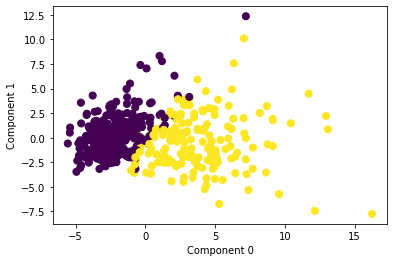

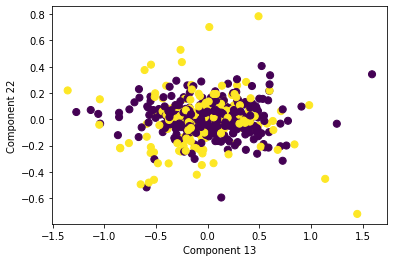

## 📢 **HAND-IN** 📢: Enter the following in **Moodle**

* Task 2a (2 Points): How many principal components should we keep and why?
* Task 2b (1 Point): Your observation.

2a: 7 - cummulative variance would explain at least 95% of the data

2b: Less components can be clearly separated but with more components they seem to overlap

### How well can we classify our data if we reduce the number of dimensions?

In the cell below, we want to find out how many principal components we need to keep to get the same (or better) performance as our baseline from Task 1.

Fill out the missing code below. Remember that we use `f1_malignant` to compare different classifiers. You should use a `LinearSVC` and you do **not** have to set any hyperparameter (`C` or `class_weight`).



### TASK 2c. How many components are needed to get the same or better result than our baseline?

In [ ]:
for n_components in range(1, 31):
  x_train_reduced = x_train_pca[:, :n_components]  # only use the first n components
  x_test_reduced = x_test_pca[:, :n_components]    # only use the first n components

  svm = LinearSVC()  # You do not need to change C and class_weight
  # fit svm and compute f1_malignant
  svm.fit(x_train_reduced, y_train)
  y_pred = svm.predict(x_test_reduced)
  # how many components result in the best score?
  f1score = f1_malignant(y_test, y_pred)
  print(f"n: {n_components} f1_score: {f1score}")


## 📢 **HAND-IN** 📢: Enter in **Moodle** whether you solved this task (2c, 2 Points).


### Task 3: A bigger Dataset (2 Points)

In this task, we will repeat the main points from Tasks 1 and 2 but for a dataset with a lot more features (100000).

The goal is to classify chemical compounds into "active" and "inactive", meaning whether they will bind to a certain receptor.

Below we load the dataset and we also include the dataset description from the openml.org website.

In [ ]:
import openml
data = openml.datasets.get_dataset(dataset_id=4137)
X, y, _, _ = data.get_data(target="class")
y = y.sparse.to_dense()
y.replace(0, 'Inactive', inplace=True)
y.replace(1, 'Active', inplace=True)

from collections import Counter
print("Number of features: ", X.shape[1])
print("Class balance: ", Counter(y))

### Description from [openml.org](https://https://www.openml.org/search?type=data&sort=runs&status=active&id=4137): 

DOROTHEA is a drug discovery dataset. Chemical compounds represented by
structural molecular features must be classified as active 
(binding to thrombin) or inactive. 
This is one of 5 datasets of the NIPS 2003 feature selection challenge.

Source:

a. Original owners The dataset with which DOROTHEA was created is one of the KDD (Knowledge Discovery in Data Mining) Cup 2001. 
The original dataset and papers of the winners of the competition are available at: http://www.cs.wisc.edu/~dpage/kddcup2001/. 
DuPont Pharmaceuticals graciously provided this data set for the KDD Cup 2001 competition.
All publications referring to analysis of this data set should acknowledge DuPont Pharmaceuticals Research Laboratories and KDD Cup 2001.

b. Donor of database This version of the database was prepared for the NIPS 2003 variable and feature selection benchmark by Isabelle Guyon, 955 Creston Road, Berkeley, CA 94708, USA (isabelle '@' clopinet.com).

Data Set Information:

Drugs are typically small organic molecules that achieve their desired activity by binding to a target site on a receptor. The first step in the discovery of a new drug is usually to identify and isolate the receptor to which it should bind, followed by testing many small molecules for their ability to bind to the target site. This leaves researchers with the task of determining what separates the active (binding) compounds from the inactive (non-binding) ones. Such a determination can then be used in the design of new compounds that not only bind, but also have all the other properties required for a drug (solubility, oral absorption, lack of side effects, appropriate duration of action, toxicity, etc.). The original data were modified for the purpose of the feature selection challenge. In particular, we added a number of distractor feature called 'probes' having no predictive power. The order of the features and patterns were randomized.

DOROTHEA -- Positive ex. -- Negative ex. -- Total Training set -- 78 -- 722 -- 800 Validation set -- 34 -- 316 -- 350 Test set -- 78 -- 722 -- 800 All -- 190 -- 1760 -- 1950

We mapped Active compounds to the target value +1 (positive examples) and Inactive compounds to the target value –1 (negative examples).

Number of variables/features/attributes: Real: 50000 Probes: 50000 Total: 100000

### Train / Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    train_size=.8,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=y,
)

### Performance Metric

The goal of the dataset is to accurately determine whether a compound is "active". Therefore we define the F1 score for the "Active" class as our target measure to assess the preformance of a classifier.

In [ ]:
def f1_active(y_true: pd.Series, y_pred: pd.Series) -> float:
  """
  Helper function to compute the F1 score for the 'Active' class

  y_true: a pd.Series object containing the ground truth labes 
          ('Inactive' or 'Active'), you will mainly pass 'y_test' here
  y_pred: a pd.Series object containing predicted labels, for example the 
          output of the '.predict' method of a classifier
  """
  return f1_score(
      y_true=y_true,
      y_pred=y_pred,
      pos_label="Active",
      average="binary",
  )

### Baseline Classifier

In [ ]:
baseline_clf = LinearSVC(class_weight='balanced')  # use class_weight="balanced" since our dataset has very high label inbalance
baseline_clf.fit(x_train, y_train)
baseline_predictions = baseline_clf.predict(x_test)

f1_baseline = f1_active(y_test, baseline_predictions)

print("Baseline F1 (Active): ", f1_baseline)

### Truncated SVD

Our dataset is very sparse. This means that a majority of the entries in our feature matrix are 0. In such cases it is wasteful to explicitely store those 0 values and instead more efficient representations are used (a naive one would for example store the row and column indices and the associated value for each non-zero entry).

Unfortunately, the `sklearn` implementation of `PCA` does not support sparse matrices and converting our data to a dense representation can lead to RAM issues. Therefore, we use a "cousin" of PCA named `TruncatedSVD` that can handle sparse data. The two algorithms work almost the same way and we will use it interchangeably here.

**Warning:** this can take a few minutes to compute.

In [ ]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=2000)
tsvd.fit(x_train)

x_train_pca = tsvd.transform(x_train)
x_test_pca = tsvd.transform(x_test)

### Visualize Variances Explained for each Component

Here we plot again the variance explained by each component and the cumulative explained variance. We limit ourselves to the first 200 components for this plot.

In [ ]:
explained_ratio = tsvd.explained_variance_ratio_

plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 201), explained_ratio[:200], marker='o', color='blue')
plt.plot(np.arange(1, 201), explained_ratio.cumsum()[:200], marker='', color='green', drawstyle="steps-post")

### What is the number of components we should keep for classification?

In [ ]:
for n_components in [10, 25, 50, 100, 200]:
  x_train_reduced = x_train_pca[:, :n_components]
  x_test_reduced = x_test_pca[:, :n_components]
  svm = LinearSVC(class_weight="balanced", max_iter=100000)  # we increase the number of optimization steps to make sure the SVM converges
  svm.fit(x_train_reduced, y_train)
  f1 = f1_active(y_test, svm.predict(x_test_reduced))
  print(n_components, f1)

### Task 3a. Runtime Considerations

You have just seen that by using dimensionality reduction, we can drastically improve the classification performance.

Another consideration is the runtime behaviour. By reducing the number of dimensions used for training we can reduce the training time by an order of magnitude.

An easy way to measure the time it takes to execute a statement, we can use the macro `%timeit` built into IPython shells and notebooks. The macro will execute the statement a number of times and report the average time to execute the statement.

In [ ]:
svm = LinearSVC(class_weight="balanced", max_iter=100000)

Below we use `%timeit` to measure how long it takes to fit an SVM on all dimensions.

In [ ]:
%timeit svm.fit(x_train, y_train)

### Task: measure the time it takes to fit an SVM on dimensionality reduced data

You can change `n_components` to change the number of dimensions used. You can reuse the `svm` variable instantiated above.

In [ ]:
n_components = 200
x_train_reduced = x_train_pca[:, :n_components]
%timeit svm.fit(x_train_reduced, y_train)
# use %timeit to measure how long it takes to fit the svm on x_train_reduced

20: 1.57 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

200: 1.87 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

## 📢 **HAND-IN** 📢: Enter the following in **Moodle**

* The average runtime for `n_components=20`
* The average runtime for `n_components=200`